In [31]:
import numpy as np
import lusee
import matplotlib.pyplot as plt
import matplotlib
import healpy as hp
import fitsio
import yaml
import scipy

In [2]:
%load_ext autoreload
%autoreload 2
import lusee

# setup SimEigenAnalysis

In [58]:
class SimEigenAnalysis:
    def __init__(self,sim_fits_path):
        self.simtitle=sim_fits_path.split('/')[-1].split('.')[0]
        print('Analyzing',self.simtitle)
        
        self.data=fitsio.read(sim_fits_path)
        self.ndata,self.ncombinations,self.nfreqs=self.data.shape
        self.freqs=np.arange(1,self.nfreqs+1)
        self.t21=lusee.mono_sky_models.T_DarkAges(self.freqs)
        self.tcmb=2.73*np.ones_like(self.t21)
        self.noise=1e-6*np.ones_like(self.t21) #K
    
    def reshape_data(self,how='concatenate'):
        if how=='concatenate':
            self.data=self.data.reshape((-1,self.nfreqs),order='F')
            assert self.data.shape==(self.ndata*self.ncombinations,self.nfreqs)
            #order=F important for concatenating beams first, instead of time first
        else:
            #to be implemented, separate beams analysis
            raise NotImplemented
            
    def set_tcmb(self,tcmb=2.73):
        self.tcmb=tcmb*np.ones_like(self.tcmb)
        
    def set_noise(self,noise=1e-6):
        self.noise=noise**np.ones_like(self.noise)
        
    def set_t21_shape(self, x_factor=1.0, y_factor=1.0):
        #x_factor implements stretch centered at the min freq = ~19Mhz
        #y_factor implements depth 
        
        self.t21_y_factor=y_factor
        self.t21*=y_factor
        
        #self.t21_x_factor=x_factor        
        #freq_min=np.argmin(self.t21)+1
        #new_freqs=np.arange(self.nfreqs//x_factor)
        #new_t21=lusee.mono_sky_models.T_DarkAges(new_freqs)
        
        #t21_interp=scipy.interpolate.interp1d((new_freqs-freq_min)*x_factor, new_t21, fill_value='extrapolate')
        #self.t21=t21_interp(self.freqs-freq_min)
        
    def compute_eigen(self):
        cov=self.data.T@self.data
        self.evals,self.evecs=np.linalg.eig(cov)
        #self.evals,self.evecs=np.real(self.evals),np.real(self.evecs)
        
    def project_signal(self,signal,nmodes_to_filter=0):
        return np.abs(self.evecs[:,nmodes_to_filter:].T @ signal)
    
    def snr(self,signal,foreground,noise):
        return np.mean(signal**2)/ (np.mean(foreground**2)+np.mean(noise**2))
    
    def compute_snr(self, step_size=60):
        
        self.t21_snr=np.zeros((self.ndata,self.nfreqs))
        self.cmb_snr=np.zeros((self.ndata,self.nfreqs))
        
        print('Computing SNR...')
        for timeidx in np.arange(self.ndata)[::step_size]:
            for nm in np.arange(self.nfreqs):
                pt21=self.project_signal(self.t21,nm)
                pcmb=self.project_signal(self.tcmb,nm)
                pdata=self.project_signal(self.data[timeidx,:],nm)
                pnoise=self.project_signal(self.noise, nm)
                self.t21_snr[timeidx:timeidx+step_size,nm]=self.snr(pt21,pdata,pnoise)
                self.cmb_snr[timeidx:timeidx+step_size,nm]=self.snr(pcmb,pdata,pnoise)
        print('done!')
        
    def plot_eigvalues(self):
        plt.scatter(self.freqs,self.evals)
        plt.title('Eigenvalues')
        plt.xlabel('Eigenmode Number')
        plt.yscale('log')
        plt.show()
        
    def plot_eigbasis_projection(self, nmodes_to_filter=0,timeidx=5000):
        
        plt.figure(figsize=(12.8,4.8))
        plt.subplot(121)
        plt.title('Global Signal')
        plt.plot(self.freqs,self.t21)
        plt.ylabel('T [K]')
        plt.xlabel(r'$\nu$ [MHz]')
        
        pt21=self.project_signal(self.t21,nmodes_to_filter)
        pcmb=self.project_signal(self.tcmb,nmodes_to_filter)
        pdata=self.project_signal(self.data[timeidx,:],nmodes_to_filter)
        pnoise=self.project_signal(self.noise, nmodes_to_filter)
        snr21=self.snr(pt21, pdata, pnoise)
        snrcmb=self.snr(pcmb, pdata, pnoise)
        
        plt.subplot(122)
        plt.title(f'Global Signal in Foreground Eigenmode Basis, {nmodes_to_filter} modes filtered')
        plt.plot(self.project_signal(self.t21,nmodes_to_filter), label=f'Original 21cm, SNR={snr21: 2.2f}')
        plt.plot(self.project_signal(self.tcmb,nmodes_to_filter), label=f'CMB, SNR={snrcmb: 2.2f}')
        plt.plot(self.project_signal(self.data[timeidx,:],nmodes_to_filter), label='Foregrounds')
        plt.xlabel('Eigenmode Number')
        plt.legend()
        plt.show()
    
    def plot_snr(self):
        plt.title('21cm SNR vs Number of Eigenmodes Filtered')
        nmodes=np.arange(45)
        for timeidx in np.arange(self.ndata)[::self.ndata//10]:
            plt.plot(nmodes,self.t21_snr[timeidx,nmodes],label=f't={timeidx}')
        plt.legend()
        plt.show()
        
        plt.title('CMB SNR vs Number of Eigenmodes Filtered')
        nmodes=np.arange(45)
        for timeidx in np.arange(self.ndata)[::self.ndata//10]:
            plt.plot(nmodes,self.cmb_snr[timeidx,nmodes],label=f't={timeidx}')
        plt.legend()
        plt.show()

Analyzing sim_ULSA_16x4degGaussBeam_1to50Hz_freqScalingFalse_highRes


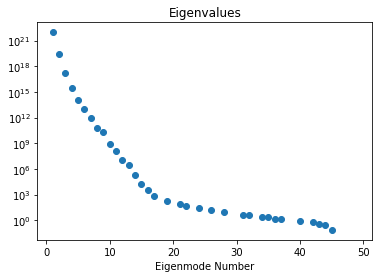

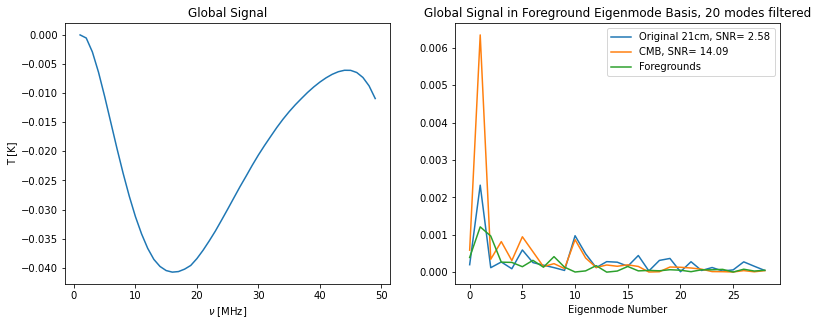

Computing SNR...
done!


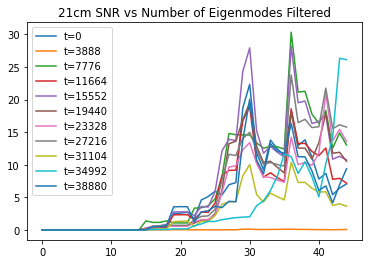

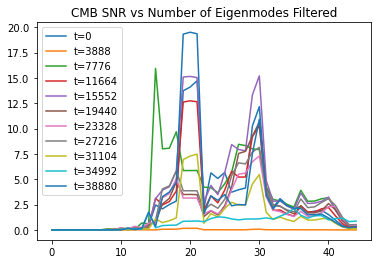

In [60]:
sea=SimEigenAnalysis('/home/rugved/Files/LuSEE/luseepy/simulation/output/old/sim_ULSA_16x4degGaussBeam_1to50Hz_freqScalingFalse_highRes.fits')
sea.reshape_data(how='concatenate')
sea.set_t21_shape(y_factor=1.0)
sea.compute_eigen()
sea.plot_eigvalues()
sea.plot_eigbasis_projection(nmodes_to_filter=20, timeidx=0)
sea.set_noise(noise=1e-6)
sea.compute_snr()
sea.plot_snr()
